<a href="https://colab.research.google.com/github/nikku1234/Random-Studies-Repo/blob/master/histo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
pip install histomicstk

     |████████████████████████████████| 983kB 2.7MB/s 
     |████████████████████████████████| 4.7MB 15.1MB/s 
     |████████████████████████████████| 204kB 36.5MB/s 
     |████████████████████████████████| 133kB 49.9MB/s 
     |████████████████████████████████| 51kB 6.3MB/s 
     |████████████████████████████████| 61kB 7.5MB/s 
     |████████████████████████████████| 317kB 47.0MB/s 
  Created wheel for large-image-source-pil: filename=large_image_source_pil-1.0.3-cp36-none-any.whl size=5514 sha256=906a0d5bc77c010841b6df382f2d491ddc9cdcc4029a1bf4fd0e9d3664615705
  Stored in directory: /root/.cache/pip/wheels/88/6b/f4/90ebbbaeebb789f977e7a86337fece0ec6de91875925edd3aa
  Created wheel for large-image-source-tiff: filename=large_image_source_tiff-1.0.3-cp36-none-any.whl size=15907 sha256=92d6dbb1fddd6c2b018a675fa46be76901e2474bf54b19f7f635ac50360110bd
  Stored in directory: /root/.cache/pip/wheels/15/25/e1/6d9a13c68ab21671d27e86be7289840ecb0003cf5c83043370
  Created wheel for large-image-

In [0]:
pip install histomicstk --find-links https://girder.github.io/large_image_wheels

Looking in links: https://girder.github.io/large_image_wheels


In [31]:
pip install histomicstk --find-links https://girder.github.io/large_image_wheels

Looking in links: https://girder.github.io/large_image_wheels


Color Deconvolution

In [32]:
!git clone https://github.com/DigitalSlideArchive/HistomicsTK.git

Cloning into 'HistomicsTK'...
remote: Enumerating objects: 230, done.
remote: Counting objects: 100% (230/230), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 16264 (delta 218), reused 203 (delta 201), pack-reused 16034
Receiving objects: 100% (16264/16264), 80.37 MiB | 35.23 MiB/s, done.
Resolving deltas: 100% (10802/10802), done.


In [0]:
!cd HistomicsTK

In [39]:
!pip install -e .

ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /content


In [0]:
!cd HistomicsTK

In [43]:
!pwd

/content


In [0]:
import histomicstk as htk 
import numpy as np
import scipy as sp
import skimage.io 
import skimage.measure 
import skimage.color
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches 
%matplotlib inline
#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 15, 15 
plt.rcParams['image.cmap'] = 'gray' 
titlesize = 24


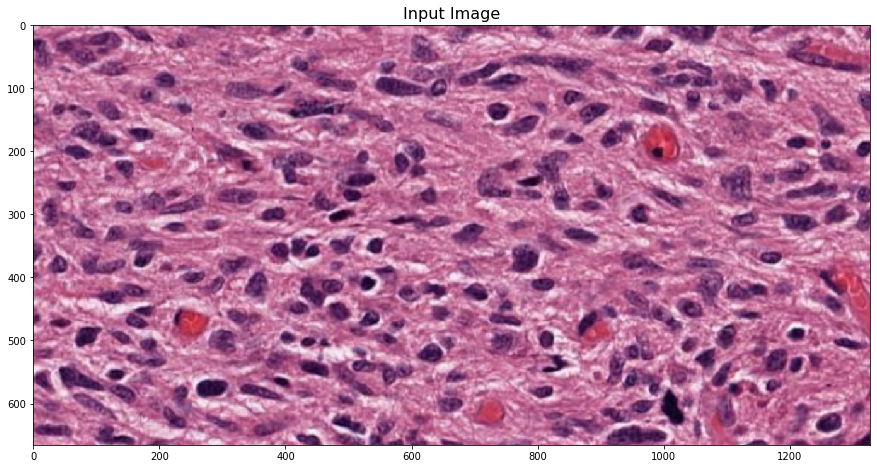

In [28]:
inputImageFile = ('https://data.kitware.com/api/v1/file/' '57802ac38d777f12682731a2/download') # H&E.png
imInput = skimage.io.imread(inputImageFile)[:, :, :3]
plt.imshow(imInput)
_ = plt.title('Input Image', fontsize=16)

Supervised color deconvolution with a known stain matrix

stain_color_map:
{'hematoxylin': [0.65, 0.7, 0.29], 'eosin': [0.07, 0.99, 0.11], 'dab': [0.27, 0.57, 0.78], 'null': [0.0, 0.0, 0.0]}


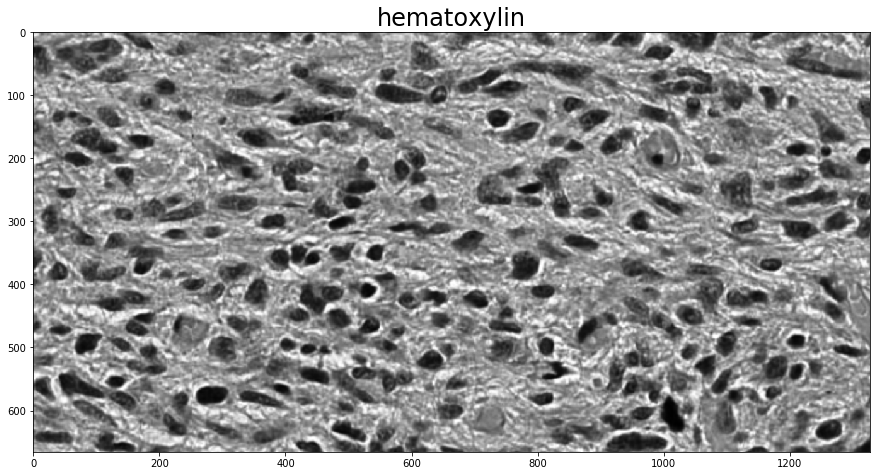

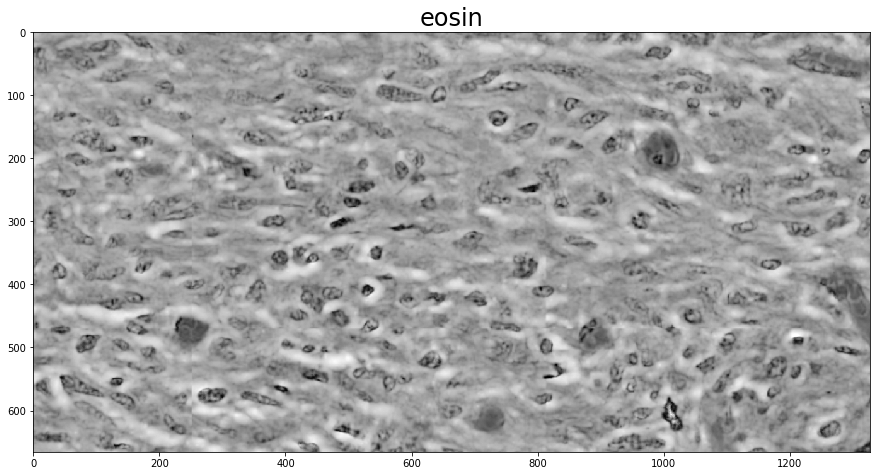

In [45]:
# create stain to color map
stain_color_map = htk.preprocessing.color_deconvolution.stain_color_map
print('stain_color_map:', stain_color_map, sep='\n')

# specify stains of input image
stains = ['hematoxylin',  # nuclei stain
          'eosin',        # cytoplasm stain
          'null']         # set to null if input contains only two stains

# create stain matrix
W = np.array([stain_color_map[st] for st in stains]).T

# perform standard color deconvolution
imDeconvolved = htk.preprocessing.color_deconvolution.color_deconvolution(imInput, W)

# Display results
for i in 0, 1:
    plt.figure()
    plt.imshow(imDeconvolved.Stains[:, :, i])
    _ = plt.title(stains[i], fontsize=titlesize)

Unsupervised color deconvolution

Sparse non-negative matrix factorization

To determine the stain vectors (somewhat) automatically, HistomicsTK has a couple different methods. The first employs Sparse Non-negative Matrix Factorization (SNMF) to estimate the stain vectors based on an initial guess. Using these methods for color deconvolution then requires two steps, one to calculate the stain vectors with one of the (rgb_)separate_stains_* functions in histomicstk.preprocessing.color_deconvolution and another to apply them to the image with color_deconvolution.

This example also makes direct use of one of the non-rgb_-prefixed stain-separation functions, which expect an image in the logarithmic SDA space. The conversion to SDA space is done with the rgb_to_sda function in histomicstk.preprocessing.color_conversion. The RGB-to-SDA conversion is parameterized by the background intensity of the image, here called I_0, which we set to 255 (full white; as a scalar it is applied across all channels) as there is no background in the image. With background available, the function background_intensity in histomicstk.preprocessing.color_normalization can be used to estimate it

/usr/local/lib/python3.6/dist-packages/histomicstk/preprocessing/color_conversion/rgb_to_sda.py:48: RuntimeWarning: divide by zero encountered in log
  im_sda = -np.log(im_rgb/(1.*I_0)) * 255/np.log(I_0)
/usr/local/lib/python3.6/dist-packages/histomicstk/preprocessing/color_conversion/rgb_to_sda.py:48: RuntimeWarning: divide by zero encountered in log
  im_sda = -np.log(im_rgb/(1.*I_0)) * 255/np.log(I_0)


Estimated stain colors (in rows):
[[0.48031803 0.78512115 0.39099791]
 [0.18892848 0.81830444 0.54284792]]


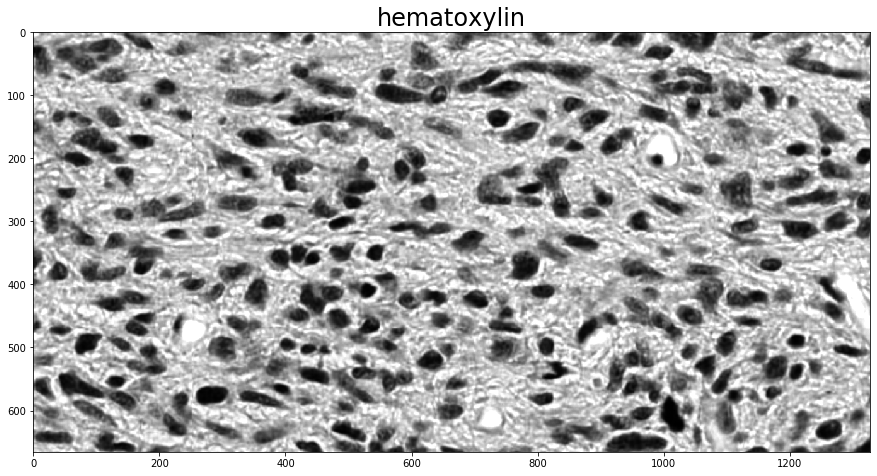

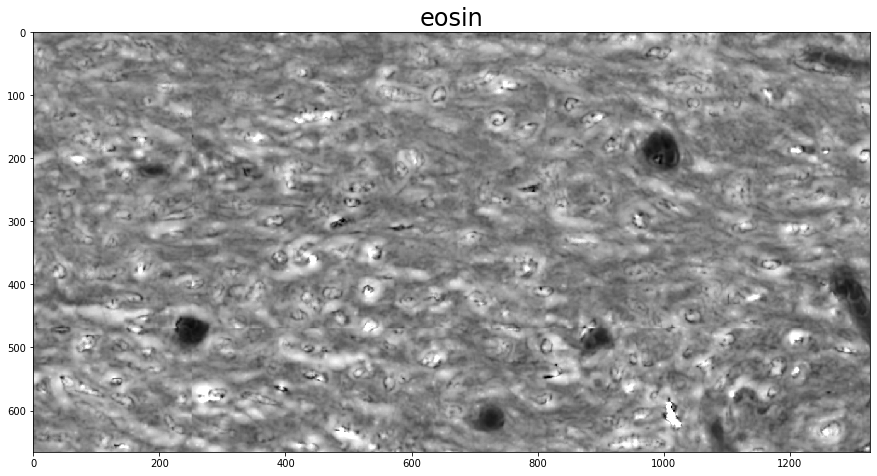

In [46]:
# create initial stain matrix
W_init = W[:, :2]

# Compute stain matrix adaptively
sparsity_factor = 0.5

I_0 = 255
im_sda = htk.preprocessing.color_conversion.rgb_to_sda(imInput, I_0)
W_est = htk.preprocessing.color_deconvolution.separate_stains_xu_snmf(
    im_sda, W_init, sparsity_factor,
)

# perform sparse color deconvolution
imDeconvolved = htk.preprocessing.color_deconvolution.color_deconvolution(
    imInput,
    htk.preprocessing.color_deconvolution.complement_stain_matrix(W_est),
    I_0,
)

print('Estimated stain colors (in rows):', W_est.T, sep='\n')

# Display results
for i in 0, 1:
    plt.figure()
    plt.imshow(imDeconvolved.Stains[:, :, i])
    _ = plt.title(stains[i], fontsize=titlesize)

The PCA-based method of Macenko et al.

Using the rgb_separate_stains_* functions is much the same, except the conversion to SDA space is done as part of the call. The PCA-based routine, unlike the SNMF-based one, does not require an initial guess, and instead automatically determines the vectors of a two-stain image. Because this determination is fully automatic, the order of the stain vector columns in the output is arbitrary. In order to determine which is which, a find_stain_index function is provided in histomicstk.preprocessing.color_deconvolution that identifies the column in the color deconvolution matrix closest to a given reference vector.

/usr/local/lib/python3.6/dist-packages/histomicstk/preprocessing/color_conversion/rgb_to_sda.py:48: RuntimeWarning: divide by zero encountered in log
  im_sda = -np.log(im_rgb/(1.*I_0)) * 255/np.log(I_0)


Estimated stain colors (rows):
[[0.16235564 0.81736416 0.55277164]
 [0.46329113 0.78963352 0.40229373]]


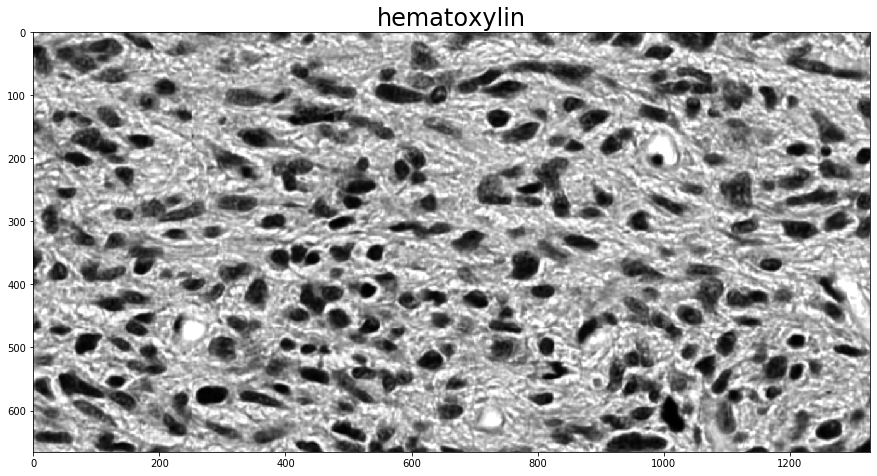

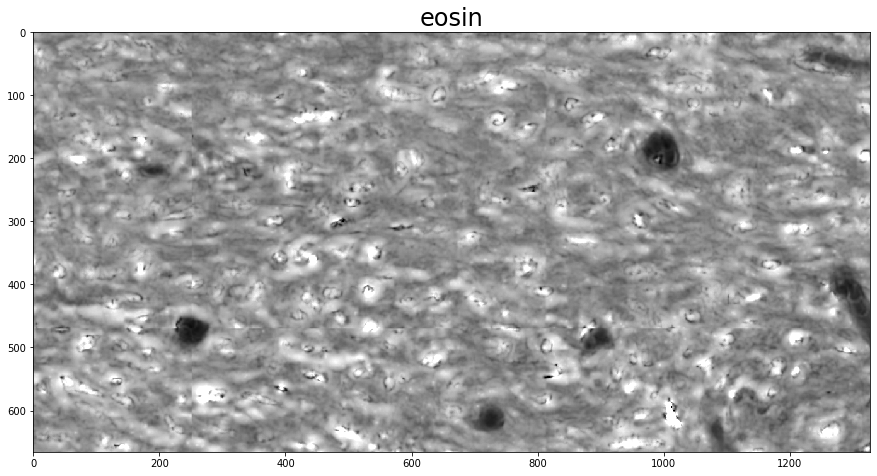

In [47]:
w_est = htk.preprocessing.color_deconvolution.rgb_separate_stains_macenko_pca(imInput, I_0)

# Perform color deconvolution
deconv_result = htk.preprocessing.color_deconvolution.color_deconvolution(imInput, w_est, I_0)

print('Estimated stain colors (rows):', w_est.T[:2], sep='\n')

# Display results
for i in 0, 1:
    plt.figure()
    # Unlike SNMF, we're not guaranteed the order of the different stains.
    # find_stain_index guesses which one we want
    channel = htk.preprocessing.color_deconvolution.find_stain_index(
        stain_color_map[stains[i]], w_est)
    plt.imshow(deconv_result.Stains[:, :, channel])
    _ = plt.title(stains[i], fontsize=titlesize)

Nuclei Segmentation

In [0]:
import histomicstk as htk

import numpy as np
import scipy as sp

import skimage.io
import skimage.measure
import skimage.color

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['image.cmap'] = 'gray'
titlesize = 24

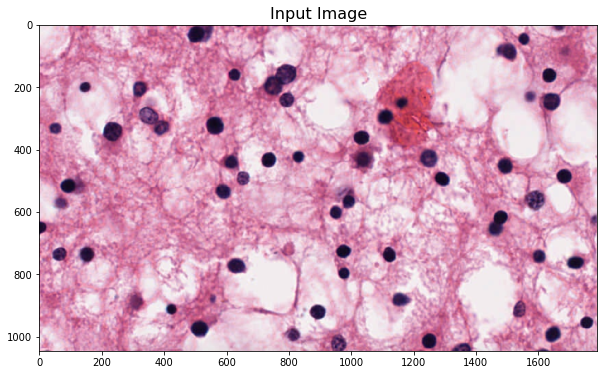

In [54]:
input_image_file = ('https://data.kitware.com/api/v1/file/'
                    '576ad39b8d777f1ecd6702f2/download')  # Easy1.png

im_input = skimage.io.imread(input_image_file)[:, :, :3]

plt.imshow(im_input)
_ = plt.title('Input Image', fontsize=16)

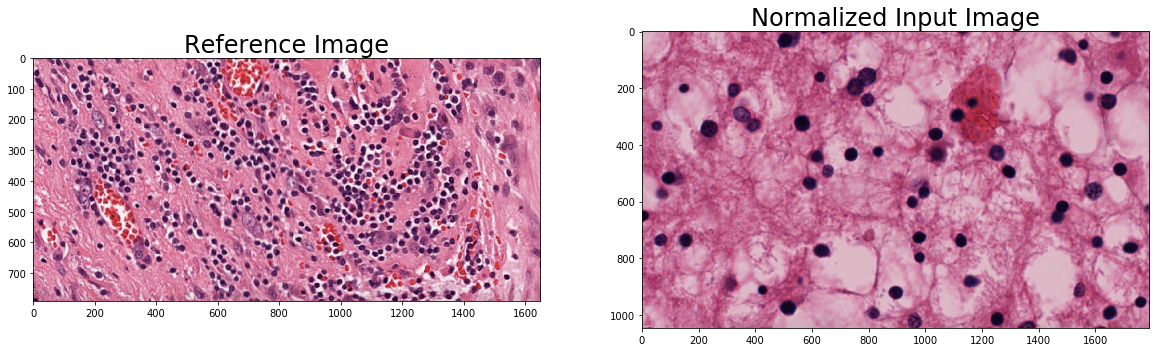

In [56]:
# Load reference image for normalization
ref_image_file = ('https://data.kitware.com/api/v1/file/'
                  '57718cc28d777f1ecd8a883c/download')  # L1.png

im_reference = skimage.io.imread(ref_image_file)[:, :, :3]

# get mean and stddev of reference image in lab space
mean_ref, std_ref = htk.preprocessing.color_conversion.lab_mean_std(im_reference)

# perform reinhard color normalization
im_nmzd = htk.preprocessing.color_normalization.reinhard(im_input, mean_ref, std_ref)

# Display results
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(im_reference)
_ = plt.title('Reference Image', fontsize=titlesize)

plt.subplot(1, 2, 2)
plt.imshow(im_nmzd)
_ = plt.title('Normalized Input Image', fontsize=titlesize)

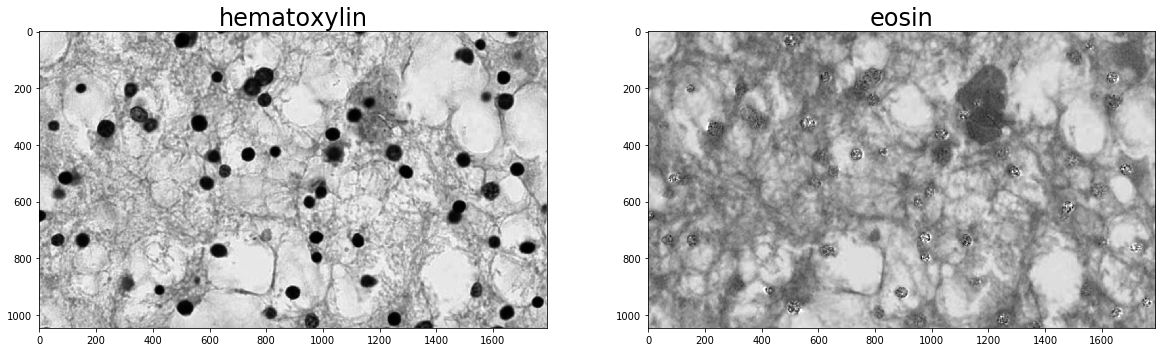

In [57]:
# create stain to color map
stainColorMap = {
    'hematoxylin': [0.65, 0.70, 0.29],
    'eosin':       [0.07, 0.99, 0.11],
    'dab':         [0.27, 0.57, 0.78],
    'null':        [0.0, 0.0, 0.0]
}

# specify stains of input image
stain_1 = 'hematoxylin'   # nuclei stain
stain_2 = 'eosin'         # cytoplasm stain
stain_3 = 'null'          # set to null of input contains only two stains

# create stain matrix
W = np.array([stainColorMap[stain_1],
              stainColorMap[stain_2],
              stainColorMap[stain_3]]).T

# perform standard color deconvolution
im_stains = htk.preprocessing.color_deconvolution.color_deconvolution(im_nmzd, W).Stains

# Display results
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(im_stains[:, :, 0])
plt.title(stain_1, fontsize=titlesize)

plt.subplot(1, 2, 2)
plt.imshow(im_stains[:, :, 1])
_ = plt.title(stain_2, fontsize=titlesize)

Number of nuclei =  65


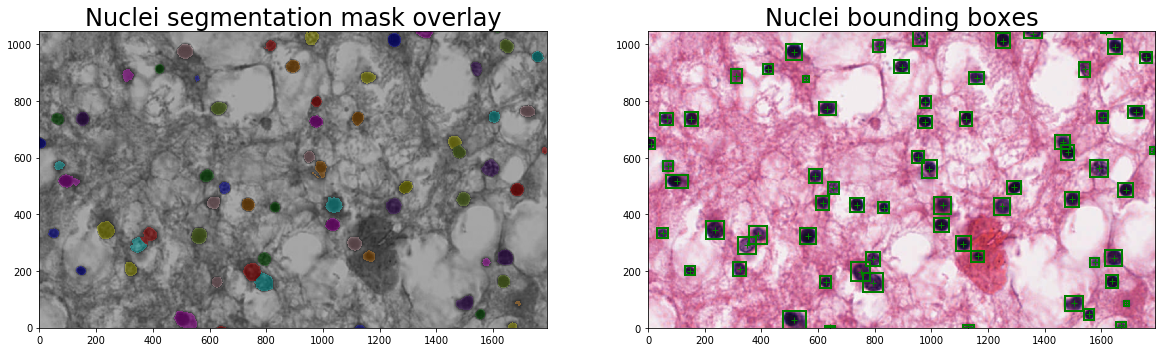

In [59]:
# get nuclei/hematoxylin channel
im_nuclei_stain = im_stains[:, :, 0]

# segment foreground
foreground_threshold = 60

im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(
    im_nuclei_stain < foreground_threshold)

# run adaptive multi-scale LoG filter
min_radius = 10
max_radius = 15

im_log_max, im_sigma_max = htk.filters.shape.cdog(
    im_nuclei_stain, im_fgnd_mask,
    sigma_min=min_radius * np.sqrt(2),
    sigma_max=max_radius * np.sqrt(2)
)

# detect and segment nuclei using local maximum clustering
local_max_search_radius = 10

im_nuclei_seg_mask, seeds, maxima = htk.segmentation.nuclear.max_clustering(
    im_log_max, im_fgnd_mask, local_max_search_radius)

# filter out small objects
min_nucleus_area = 80

im_nuclei_seg_mask = htk.segmentation.label.area_open(
    im_nuclei_seg_mask, min_nucleus_area).astype(np.int)

# compute nuclei properties
objProps = skimage.measure.regionprops(im_nuclei_seg_mask)

print ('Number of nuclei = ', len(objProps))

# Display results
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(skimage.color.label2rgb(im_nuclei_seg_mask, im_input, bg_label=0), origin='lower')
plt.title('Nuclei segmentation mask overlay', fontsize=titlesize)

plt.subplot(1, 2, 2)
plt.imshow( im_input )
plt.xlim([0, im_input.shape[1]])
plt.ylim([0, im_input.shape[0]])
plt.title('Nuclei bounding boxes', fontsize=titlesize)

for i in range(len(objProps)):

    c = [objProps[i].centroid[1], objProps[i].centroid[0], 0]
    width = objProps[i].bbox[3] - objProps[i].bbox[1] + 1
    height = objProps[i].bbox[2] - objProps[i].bbox[0] + 1

    cur_bbox = {
        "type":        "rectangle",
        "center":      c,
        "width":       width,
        "height":      height,
    }

    plt.plot(c[0], c[1], 'g+')
    mrect = mpatches.Rectangle([c[0] - 0.5 * width, c[1] - 0.5 * height] ,
                               width, height, fill=False, ec='g', linewidth=2)
    plt.gca().add_patch(mrect)

Positive Pixel Count

In [0]:
# Configuration and imports of other libraries
from __future__ import print_function

import large_image
%matplotlib inline
import matplotlib.pyplot as plt
import skimage.io

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 15, 15
plt.rcParams['image.cmap'] = 'gray'

In [0]:
# Import and alias positive_pixel_count
import histomicstk.segmentation.positive_pixel_count as ppc

Analyzing a small image with count_image

Input image


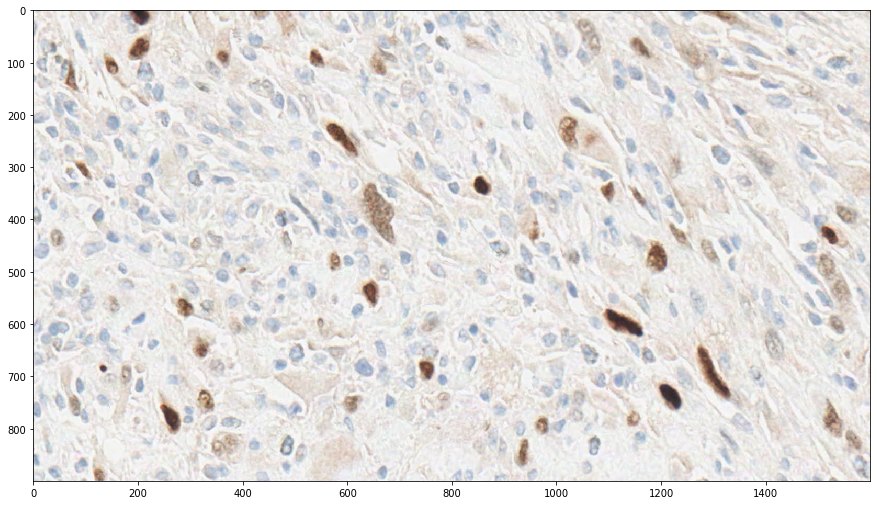

In [62]:
image_url = ('https://data.kitware.com/api/v1/file/'
             '598b71ee8d777f7d33e9c1d4/download')  # DAB.png

im_input = skimage.io.imread(image_url)

print('Input image')
plt.imshow(im_input)
plt.show()

In [0]:
def count_and_label(params):
    "Compute the label image with count_image, and then display it"
    label_image = ppc.count_image(im_input, params)[1]
    plt.imshow(label_image)
    plt.show()

In [0]:
template_params = ppc.Parameters(
    hue_value=0.05,
    hue_width=0.15,
    saturation_minimum=0.05,
    intensity_upper_limit=0.95,
    intensity_weak_threshold=0.65,
    intensity_strong_threshold=0.35,
    intensity_lower_limit=0.05,
)

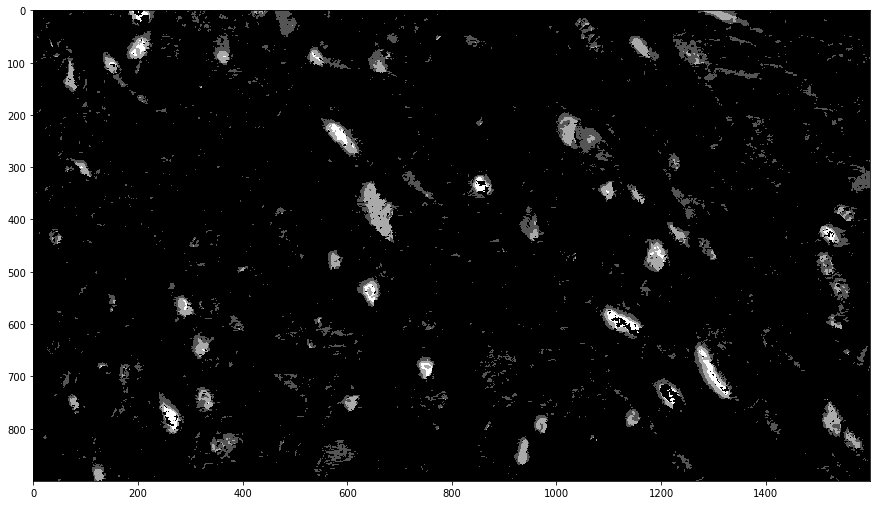

In [65]:
count_and_label(template_params)

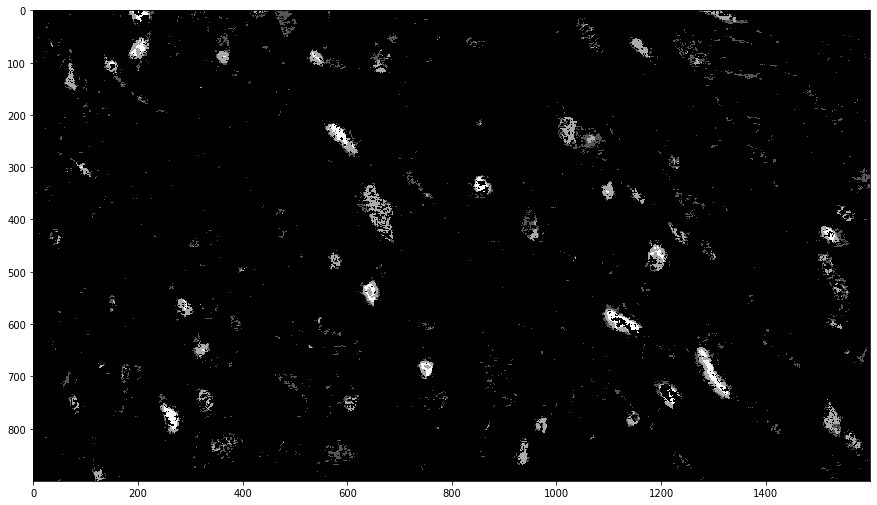

In [66]:
count_and_label(template_params._replace(hue_value=0.))

In [67]:
stats, label_image = ppc.count_image(im_input, template_params)

def pp_namedtuple(t):
    "Pretty-print a namedtuple by printing each field on its own line and left-aligning all values"
    print(type(t).__name__)
    maxlen = max(map(len, t._fields))
    for f in t._fields:
        print(f, getattr(t, f), sep=':' + ' ' * (maxlen - len(f)) + '\t')

pp_namedtuple(stats)

Output
NumberWeakPositive:             	62163
NumberPositive:                 	24459
NumberStrongPositive:           	4948
IntensitySumWeakPositive:       	49554.65359477124
IntensitySumPositive:           	12907.145098039215
IntensitySumStrongPositive:     	1423.4183006535948
IntensityAverage:               	0.6976653597626302
RatioStrongToTotal:             	0.054035164355138145
IntensityAverageWeakAndPositive:	0.7210846977997558


In [0]:
# Comment this out (or just don't run it) once you have the file
!curl -OJ 'https://data.kitware.com/api/v1/file/598b5ee88d777f7d33e9c1d1/download'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 15 1668M   15  260M    0     0  1968k      0  0:14:28  0:02:15  0:12:13     0

In [0]:
# Set up a basic configuration.  Change as needed.
import dask.distributed

dask.distributed.Client()

In [0]:
slide_path = 'TCGA-DX-A6BG-01Z-00-DX2.34763958-0613-4069-9ACC-13D6633FE415.svs'
region = dict(
    left=50000, top=35000,
    width=1600, height=900,
)

ts = large_image.getTileSource(slide_path)
im_region = ts.getRegion(region=region, format=large_image.tilesource.TILE_FORMAT_NUMPY)[0]

print("The region")
plt.imshow(im_region)
plt.show()

In [0]:
stats, label_image = ppc.count_slide(slide_path, template_params, region=region, make_label_image=True)
pp_namedtuple(stats)
plt.imshow(label_image)
plt.show()

In [0]:
# Note that we still return a tuple, though it now has length 1.
stats_dask, = ppc.count_slide(slide_path, template_params, region=region, tile_grouping=1)
pp_namedtuple(stats_dask)

In [0]:
print("stats_dask - stats:")
pp_namedtuple(ppc.Output(**{f: getattr(stats_dask, f) - getattr(stats, f) for f in ppc.Output._fields}))

In [0]:
large_region = dict(
    left=60e3, top=30e3,
    width=30e3, height=30e3,
)

stats, = %time ppc.count_slide(slide_path, template_params, large_region)

pp_namedtuple(stats)

In [0]:
pp_namedtuple(template_params)
print('\nRegion:', region)

In [0]:
%%script sh
# Stats and label image output must be specified via file arguments to
# --returnparameterfile and --outputLabelImage, respectively.
python ../../server/PositivePixelCount/PositivePixelCount.py \
    'TCGA-DX-A6BG-01Z-00-DX2.34763958-0613-4069-9ACC-13D6633FE415.svs' \
    0.05 0.15 0.05 0.95 0.65 0.35 0.05 --region 50000,35000,1600,900 \
    --returnparameterfile stats.txt --outputLabelImage labelImage.png 2>/dev/null

In [0]:
print("stats.txt:")
for l in open('stats.txt'):
    print(l.rstrip())

print("\nlabelImage.png:")
plt.imshow(skimage.io.imread('labelImage.png'))
plt.show()